In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import copy
import pandas as pd
import seaborn as sns
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import gym 
import gym_keygrid

In [54]:
DISPLAY_EVERY_N_EPISODES = 10

In [55]:
def states_display(state_seq, title=None, figsize=(10,10), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=None):
    state_array = np.array(state_seq).T

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(state_array, annot=annot, fmt=fmt, linewidths=linewidths, square=square, cbar=cbar, cmap=cmap, ax=ax)
    
    if title is not None:
        ax.set_title(title)

    if ax is None:
        plt.show()
    else:
        return ax
    
def policy_display(policy):
    labels = np.vectorize(lambda x: env.actions_dic[x])(policy)
    states_display(policy.T, title="Policy", cbar=False, annot=labels, fmt='s')

In [56]:
def td_learning(policy, environment, alpha=0.1, alpha_factor=0.995, gamma=0.95, display=False):
    v_array = np.zeros(environment.states_n)
    v_array_tmp = np.zeros(environment.states_n)
    
    for e in range(env._max_episode_steps):
        value_function_history.append(v_array.copy())

        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        value_function_history.append(v_array.copy())
        alpha_history.append(alpha)

        s = environment.reset()
        d = False
        t = 0
        
        while (not d) and (t < environment._max_episode_steps):
            ns, r, d, _ = environment.step(policy[s])
            td_error = (r + gamma*v_array[ns] - v_array[s])
            v_array[s] = v_array[s] + alpha*td_error
                
            s = ns
            t+=1

        if display and e%DISPLAY_EVERY_N_EPISODES==0:
            states_display(v_array)
        
    return v_array

In [6]:
value_function_history = []
alpha_history = []

env = gym.make('keygrid-v0', grid_length=10)

policy = {s:0 for s in env.states}
for j in range(env.len):
    policy[(j, 0)] = 1
    policy[(j, 1)] = -1
policy[(env.key_pos, 0)] = 0

<AxesSubplot:title={'center':'Value function'}>

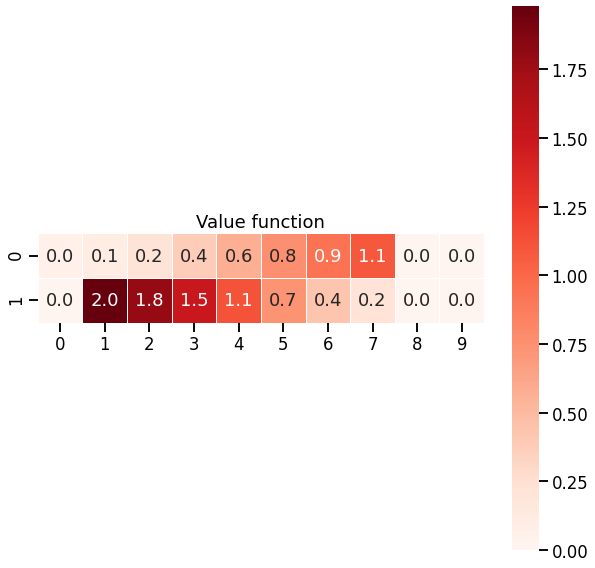

In [7]:
v_array = td_learning(policy, env, display=False)

states_display(v_array, title="Value function", cbar=True, cmap="Reds")

In [31]:
import random

def argmax_tiebreaker(arr):
    return np.random.choice(np.flatnonzero(arr == arr.max()))

def greedy_policy(state, q_array):
    action_idx = argmax_tiebreaker(q_array[state[0], state[1], :])
    return action_idx

def epsilon_greedy_policy(state, q_array, epsilon, actions):
    if np.random.rand() > epsilon:
        action_idx = greedy_policy(state, q_array)
    else:
        action_idx = random.choice(range(len(actions)))
    return action_idx

def qtable_display(q_array, title=None, figsize=(4,4), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds"):
    num_actions = q_array.shape[-1]

    global_figsize = list(figsize)
    global_figsize[0] *= num_actions
    fig, ax_list = plt.subplots(ncols=num_actions, figsize=global_figsize)   # Sample figsize in inches

    for action_index in range(num_actions):
        ax = ax_list[action_index]
        state_seq = q_array[:,:,action_index]
        states_display(state_seq, title=f'Action {action_index}', figsize=figsize, annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=ax)

    plt.suptitle(title)
    plt.show()

def q_learning(environment, alpha=0.1, alpha_factor=0.9995, gamma=0.9, epsilon=0.5, num_episodes=5000, display=True):
    num_states = environment.states_n
    num_actions = environment.actions_n
    q_array = np.zeros([*num_states, num_actions])   # Initial Q table

    for episode_index in range(num_episodes):
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            qtable_display(q_array, title="Q table", cbar=True)
            
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)

        # Update alpha
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        current_state = environment.reset()
        
        
        t = 0
        while t < env._max_episode_steps:
            action_idx = epsilon_greedy_policy(current_state, q_array, epsilon, env.actions)
            action = env.actions[action_idx]
            next_state, reward, final_state, _ = environment.step(action, render=False)
            
            td_error = reward+gamma*max(q_array[next_state[0], next_state[1], :]) - q_array[current_state[0], current_state[1], action_idx]
            q_array[current_state[0], current_state[1], action_idx] += alpha*(td_error)

            current_state = next_state
            
            if final_state:
                break

            t += 1

    return q_array

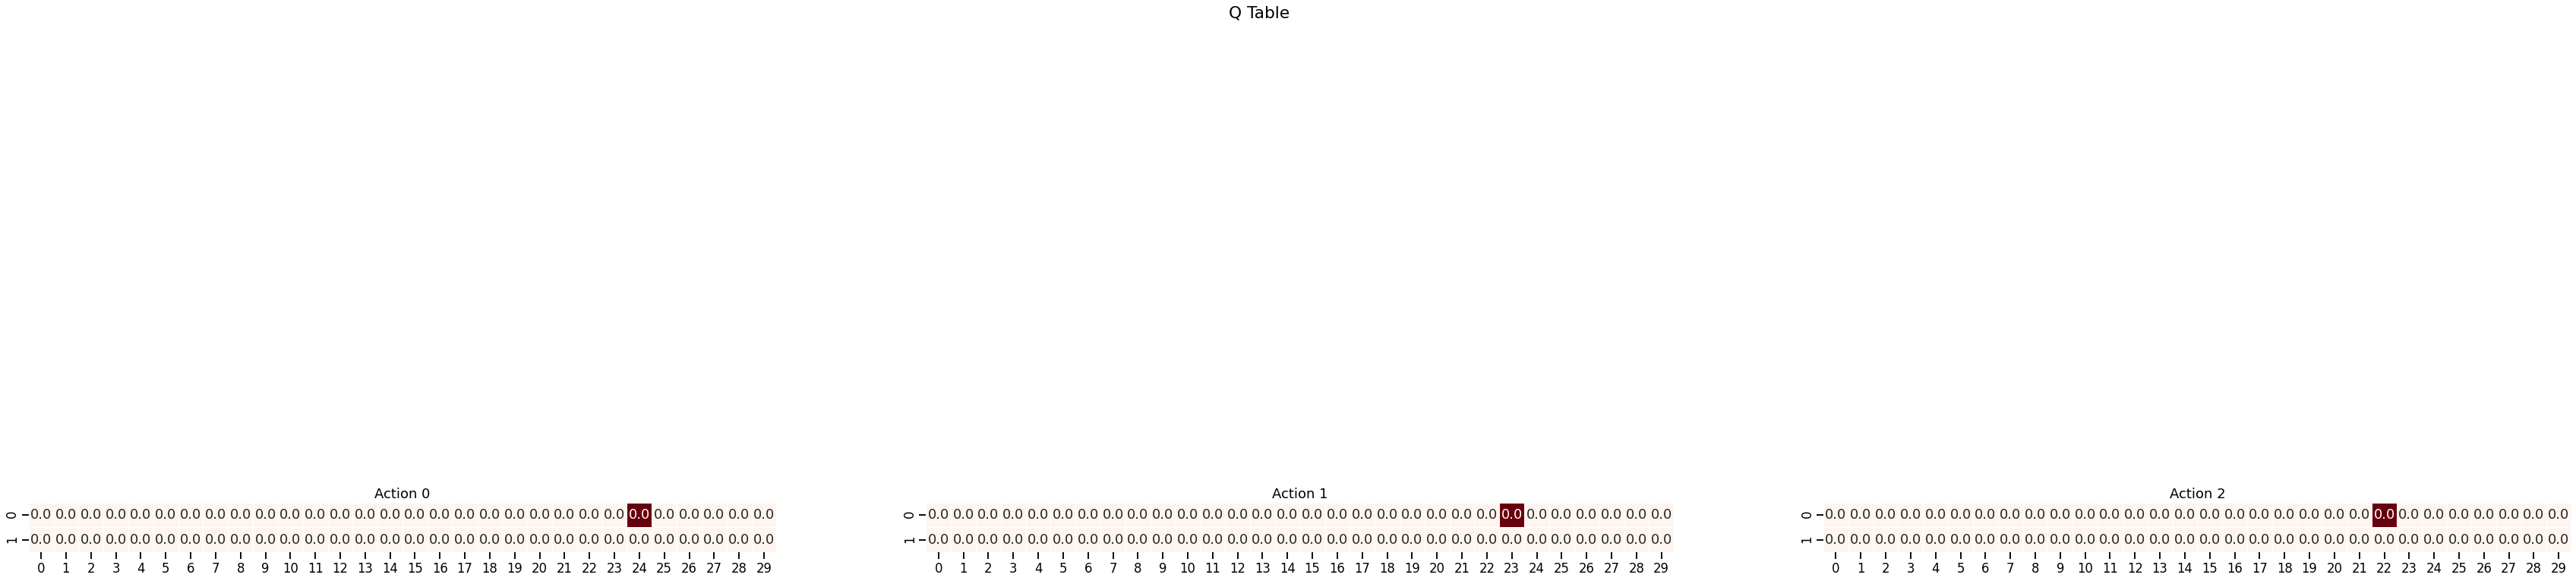

In [36]:
q_array_history = []
alpha_history = []

env = gym.make('keygrid-v0', grid_length=30)

q_array = q_learning(env, display=False, num_episodes=50000)

env.close()

qtable_display(q_array, title="Q Table", cbar=True, figsize=(20, 20))

In [10]:
action_map = np.vectorize(lambda x: env.actions[int(x)])
policy = action_map(np.argmax(q_array, axis=2))

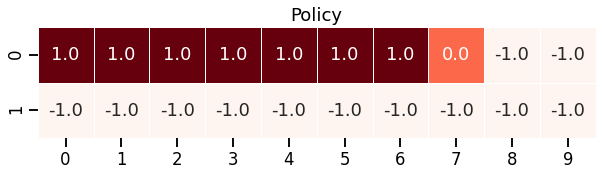

In [11]:
_ = states_display(policy, title="Policy", cbar=False)

In [12]:
import copy 

class NN_numpy:
    def __init__(self, i=2, h1=64, h2=64, out=3, init_weights=None):
        if init_weights:
            self.init_weights(init_weights)
        else:
            self.weights = {
                'w1': NN.xavier_init(i, h1),
                'b1': np.zeros((1, h1)),
                'w2': NN.xavier_init(h1, h2),
                'b2': np.zeros((1, h2)),
                'w3': NN.xavier_init(h2, out),
                'b3': np.zeros((1, out))
            }
    
    @staticmethod
    def xavier_init(h1, h2):
        glorot = 1.0*np.sqrt(6.0/(h1+h2))
        size = (h1, h2)
        return np.random.uniform(-glorot, glorot, size)
        
    @staticmethod
    def relu(l):
        return np.where(l<0, 0, l) 

    @staticmethod
    def softmax(l):
        e_x = np.exp(l - np.max(l))
        return e_x / e_x.sum(axis=-1)
            
    def init_weights(self, init_weights):
        self.weights = copy.deepcopy(init_weights)
    
    def forward(self, inp):
        w1 = self.weights['w1']
        b1 = self.weights['b1']
        w2 = self.weights['w2']
        b2 = self.weights['b2']
        w3 = self.weights['w3']
        b3 = self.weights['b3']
        
        l1 = NN.relu(inp @ w1 + b1)
        l2 = NN.relu(l1 @ w2 + b2)
        out = NN.softmax(l2 @ w3 + b3)
        
        return out

In [13]:
class GA_Agent:
    def __init__(self, inp=2, h1=64, h2=64, out=3, mu_prob=0.1):
        self.inp = inp
        self.h1 = h1
        self.h2 = h2
        self.n_out = out
        self.mu_prob = mu_prob
        
        self.net = NN(inp, h1, h2, out)
        self.score = 0
        
    def reborn(self, parents):
        parent1, parent2 = parents
        for key in self.net.weights:
            mask = np.random.choice([0,1], size=self.net.weights[key].shape, p=[.5,.5])
            self.net.weights[key] = np.where(mask==1, parent1.net.weights[key], parent2.net.weights[key])
                
    def mutate(self):
        for key in self.net.weights:
            mask = np.random.choice([0,1], size=self.net.weights[key].shape, p=[1-self.mu_prob,self.mu_prob])
            
            random = NN.xavier_init(mask.shape[0],mask.shape[1])
            self.net.weights[key] = np.where(mask==1,self.net.weights[key]+random,self.net.weights[key])

    def get_action(self, state):
        if isinstance(state, tuple):
            state = np.array(state)
        if(state.shape[0] != 1):
            state = state.reshape(1,-1)
        
        return env.actions[argmax_tiebreaker(self.net.forward(state))]

    def evaluate(self, env, pr=False):
        state = env.reset()
        score = 0
        t = 0
        done = False
        
        while not done and t < env._max_episode_steps:
            state, reward, done, _ = env.step(self.get_action(state))
            if pr:
                print(state, self.get_action(state), reward)
            score += reward
            
            t += 1

        self.score = score

        return score

In [14]:
from scipy.special import softmax

def select_next_gen(agent_set, n_selected):
    n_best = int(n_selected*0.8)
    n_random = n_selected - n_best

    sorted_agents = sorted(agent_set, key = lambda agent : agent.score, reverse = True)
        
    next_gen = sorted_agents[:n_best]
    next_random = np.random.choice(sorted_agents, size = n_random, replace = False)
    for rand in next_random:
        next_gen.append(rand)
    not_selected = []
    for agent in agent_set:
        if agent not in next_gen:
            not_selected.append(agent)
    return sorted_agents[0], next_gen, not_selected

def select_parents(agent_set):
    return np.random.choice(agent_set, size = 2, p = NN.softmax([agent.score for agent in agent_set]))

def get_best_agent(best_agents):
    return max(best_agents, key=lambda x: x.score)

In [15]:
inp = 2
h1 = 64
h2 = 64
out = 3
mu_prob = 0.2
generation = 50
population = 80

prop_selected = 0.3

env = gym.make('keygrid-v0', grid_length=6)

n_selected = int(prop_selected * population)
best_agents = []

agent_set = [GA_Agent(inp, h1, h2, out, mu_prob) for i in range(population)]

best, selected, next_children = select_next_gen(agent_set, n_selected)

best_agents.append(best)
score_evolution = []
time_evolution = []


print("\n"+"*"*100)
print("TRAINING START\n")

for gen in range(1, generation+1):
    for new_child in next_children:
        parents = select_parents(selected)
        new_child.reborn(parents)
        new_child.mutate()
        
    for agent in agent_set:
        agent.evaluate(env)
        
    best, selected, next_children = select_next_gen(agent_set, n_selected)
    best_agents.append(best)

    print("Generation:",gen,"Score:",best.score)
    score_evolution.append(best.score)
    
print("\n"+"*"*100)
print("TRAINING ENDED\n")


****************************************************************************************************
TRAINING START

Generation: 1 Score: 1
Generation: 2 Score: 1
Generation: 3 Score: 1
Generation: 4 Score: 1
Generation: 5 Score: 1
Generation: 6 Score: 1
Generation: 7 Score: 1
Generation: 8 Score: 1
Generation: 9 Score: 1
Generation: 10 Score: 1
Generation: 11 Score: 1
Generation: 12 Score: 1
Generation: 13 Score: 1
Generation: 14 Score: 1
Generation: 15 Score: 1
Generation: 16 Score: 1
Generation: 17 Score: 1
Generation: 18 Score: 1
Generation: 19 Score: 1
Generation: 20 Score: 1
Generation: 21 Score: 1
Generation: 22 Score: 1
Generation: 23 Score: 1
Generation: 24 Score: 1
Generation: 25 Score: 1
Generation: 26 Score: 1
Generation: 27 Score: 1
Generation: 28 Score: 1
Generation: 29 Score: 1
Generation: 30 Score: 1
Generation: 31 Score: 1
Generation: 32 Score: 1
Generation: 33 Score: 1
Generation: 34 Score: 1
Generation: 35 Score: 1
Generation: 36 Score: 1
Generation: 37 Score: 1
Gen

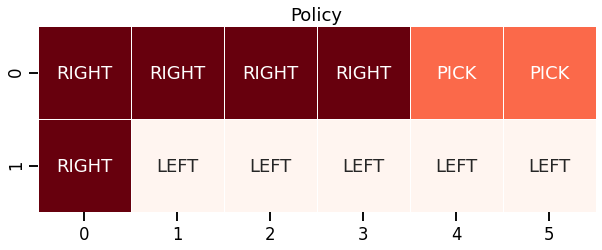

In [16]:
policy  = np.array([get_best_agent(best_agents).get_action(x) for x in env.states])
policy = policy.reshape((2, -1), order='F')
policy_display(policy)

In [22]:
env = gym.make('keygrid-v0', grid_length=15)

In [23]:
env.render()

| A | * | * | * | * | * | * | * | * | * | * | K | * | * | * | 


In [20]:
class ES_Agent(NN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.inp = inp
        self.h1 = h1
        self.h2 = h2
        self.n_out = out
        
        self.score = 0

    def get_action(self, state):
        if isinstance(state, tuple):
            state = np.array(state)
        if(state.shape[0] != 1):
            state = state.reshape(1,-1)
        
        return env.actions[argmax_tiebreaker(self.forward(state))]

    def evaluate(self, env, pr=False):
        state = env.reset()
        score = 0
        t = 0
        done = False
        
        while not done and t < env._max_episode_steps:
            state, reward, done, _ = env.step(self.get_action(state))
            if pr:
                print(state, self.get_action(state), reward)
            score += reward
            
            t += 1

        self.score = score

        return score
    
def create_pop(agent, npop=2, sigma=0.1):
    new_agents = [ES_Agent(init_weights=agent.weights) for _ in range(npop)]
    
    N = {}

    for key, val in agent.weights.items():
        shape = val.shape
        N[key] = np.random.randn(*shape, npop)

    for i, new_agent in enumerate(new_agents):
        for key in new_agent.weights:
            new_agent.weights[key] += sigma * N[key][:,:,i]
    
    return new_agents, N

In [21]:
npop = 100
alpha = 0.1
sigma = 0.25
generation = 300

agent = ES_Agent()

print("\n"+"*"*100)
print("TRAINING START\n")

for gen in range(generation):
    new_agents, N = create_pop(agent, npop=npop, sigma=sigma)
    R = np.zeros(npop)
    
    for i, n_a in enumerate(new_agents):
        R[i] = n_a.evaluate(env)
    
    if np.std(R) == 0:
        A = np.zeros(npop)
    else:
        A = (R - np.mean(R)) / np.std(R)
    
    for key in agent.weights:
        agent.weights[key] += alpha/(npop*sigma) * (N[key] @ A)
        
    print("Generation:", gen, "Score:", agent.score)

print("\n"+"*"*100)
print("TRAINING ENDED\n")


****************************************************************************************************
TRAINING START

Generation: 0 Score: 0
Generation: 1 Score: 0
Generation: 2 Score: 0
Generation: 3 Score: 0
Generation: 4 Score: 0
Generation: 5 Score: 0
Generation: 6 Score: 0
Generation: 7 Score: 0
Generation: 8 Score: 0
Generation: 9 Score: 0
Generation: 10 Score: 0
Generation: 11 Score: 0
Generation: 12 Score: 0
Generation: 13 Score: 0
Generation: 14 Score: 0
Generation: 15 Score: 0
Generation: 16 Score: 0
Generation: 17 Score: 0
Generation: 18 Score: 0
Generation: 19 Score: 0
Generation: 20 Score: 0
Generation: 21 Score: 0
Generation: 22 Score: 0
Generation: 23 Score: 0
Generation: 24 Score: 0
Generation: 25 Score: 0
Generation: 26 Score: 0
Generation: 27 Score: 0
Generation: 28 Score: 0
Generation: 29 Score: 0
Generation: 30 Score: 0
Generation: 31 Score: 0
Generation: 32 Score: 0
Generation: 33 Score: 0
Generation: 34 Score: 0
Generation: 35 Score: 0
Generation: 36 Score: 0
Gene

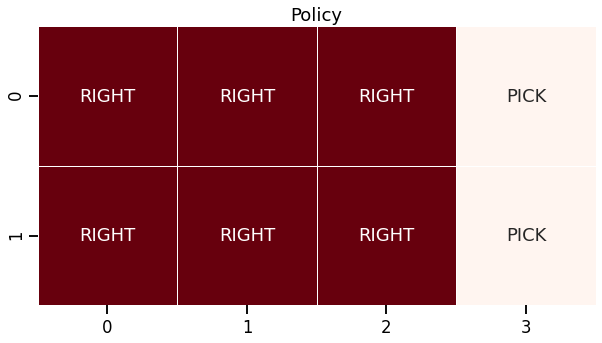

In [174]:
policy  = np.array([agent.get_action(x) for x in env.states])
policy = policy.reshape((2, -1), order='F')
policy_display(policy)

In [206]:
from sklearn.neighbors import NearestNeighbors

In [244]:
class NS_Agent(NN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.inp = inp
        self.h1 = h1
        self.h2 = h2
        self.n_out = out
        
        self.score = 0

    def get_action(self, state):
        if isinstance(state, tuple):
            state = np.array(state)
        if(state.shape[0] != 1):
            state = state.reshape(1,-1)
        
        return env.actions[argmax_tiebreaker(self.forward(state))]

    def get_bc(self, env):
        state = env.reset()
        t = 0
        done = False

        while not done and t < env._max_episode_steps:
            state, reward, done, _ = env.step(self.get_action(state))
            t += 1
        
        bc = state
        return bc
        
        
    def evaluate(self, env):
        state = env.reset()
        score = 0
        t = 0
        done = False
        
        while not done and t < env._max_episode_steps:
            state, reward, done, _ = env.step(self.get_action(state))
            score += reward
            
            t += 1

        self.score = score

        return score
    
def create_pop(agent, npop=2, sigma=0.1):
    new_agents = [NS_Agent(init_weights=agent.weights) for _ in range(npop)]
    
    N = {}

    for key, val in agent.weights.items():
        shape = val.shape
        N[key] = np.random.randn(*shape, npop)

    for i, new_agent in enumerate(new_agents):
        for key in new_agent.weights:
            new_agent.weights[key] += sigma * N[key][:,:,i]
    
    return new_agents, N

In [259]:
npop = 40
alpha = 0.1
sigma = 1
generation = 100

K = 3
archive = set()
while len(archive) != K:
    archive.add(NS_Agent().get_bc(env))

agent = NS_Agent()


print("\n"+"*"*100)
print("TRAINING START\n")

for gen in range(generation):
    new_agents, N = create_pop(agent, npop=npop, sigma=sigma)
    F = np.zeros(npop)
    R = []
    
    for i, n_a in enumerate(new_agents):
        F[i] = n_a.evaluate(env)
        R.append(n_a.get_bc(env)) 
    
#     print(R)
    
    nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(np.array(list(archive)))
    R = np.mean(nbrs.kneighbors(np.array(R))[0], axis=1)

    if np.std(R) == 0:
        A = np.zeros(npop)
    else:
        A = (R - np.mean(R)) / np.std(R)
        
    for key in agent.weights:
        agent.weights[key] += alpha/(npop*sigma) * (N[key] @ A)
    
    archive.add(agent.get_bc(env))
    print(archive)
#     print(agent.weights['w1'][0])
    
#     print("Generation:", gen, "Score:", print(F))

print("\n"+"*"*100)
print("TRAINING ENDED\n")


****************************************************************************************************
TRAINING START

{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0), (0, 0), (5, 0)}
{(1, 0)

In [ ]:
class QD_Agent(NN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.inp = inp
        self.h1 = h1
        self.h2 = h2
        self.n_out = out
        
        self.score = 0

    def get_action(self, state):
        if isinstance(state, tuple):
            state = np.array(state)
        if(state.shape[0] != 1):
            state = state.reshape(1,-1)
        
        return env.actions[argmax_tiebreaker(self.forward(state))]

    def get_bc(self, env):
        state = env.reset()
        t = 0
        done = False

        while not done and t < env._max_episode_steps:
            state, reward, done, _ = env.step(self.get_action(state))
            t += 1
        
        bc = state
        return bc
        
        
    def evaluate(self, env):
        state = env.reset()
        score = 0
        t = 0
        done = False
        
        while not done and t < env._max_episode_steps:
            state, reward, done, _ = env.step(self.get_action(state))
            score += reward
            
            t += 1

        self.score = score

        return score
    
def create_pop(agent, npop=2, sigma=0.1):
    new_agents = [QD_Agent(init_weights=agent.weights) for _ in range(npop)]
    
    N = {}

    for key, val in agent.weights.items():
        shape = val.shape
        N[key] = np.random.randn(*shape, npop)

    for i, new_agent in enumerate(new_agents):
        for key in new_agent.weights:
            new_agent.weights[key] += sigma * N[key][:,:,i]
    
    return new_agents, N

In [ ]:
npop = 40
alpha = 0.1
sigma = 1
generation = 100

K = 3
archive = set()
while len(archive) != K:
    archive.add(QD_Agent().get_bc(env))

agent = QD_Agent()


print("\n"+"*"*100)
print("TRAINING START\n")

for gen in range(generation):
    new_agents, N = create_pop(agent, npop=npop, sigma=sigma)
    F = np.zeros(npop)
    D = []
    
    for i, n_a in enumerate(new_agents):
        F[i] = n_a.evaluate(env)
        D.append(n_a.get_bc(env)) 
    
#     print(R)
    
    nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(np.array(list(archive)))
    D = np.mean(nbrs.kneighbors(np.array(R))[0], axis=1)

    R = normalize_array(F) + normalize_array(D)
    
    if np.std(R) == 0:
        A = np.zeros(npop)
    else:
        A = (R - np.mean(R)) / np.std(R)
        
    for key in agent.weights:
        agent.weights[key] += alpha/(npop*sigma) * (N[key] @ A)
    
    archive.add(agent.get_bc(env))
    print(archive)
#     print(agent.weights['w1'][0])
    
#     print("Generation:", gen, "Score:", print(F))

print("\n"+"*"*100)
print("TRAINING ENDED\n")

### Reinforce Algo

In [57]:
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow import keras

In [74]:
class NNtf:
    def __init__(self, *args, **kwargs):
        self.build_model(*args, **kwargs)
        
    def build_model(self, i=2, h1=32, h2=32, out=3, init_weights=None):
        inp = keras.Input(shape=(i, ))
        x = keras.layers.Dense(h1, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(inp)
        x = keras.layers.Dense(h2, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(x)
        outp = keras.layers.Dense(out, activation='linear', use_bias=True, kernel_initializer='glorot_uniform')(x)
        
        self.lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.99)
        self.optimizer = keras.optimizers.Adam(learning_rate=self.lr)
        self.model = keras.Model(inputs=inp, outputs=outp)        

        self.weights = self.model.trainable_weights
        
    def forward(self, inp):
        if not isinstance(inp, tf.Tensor):
            inp = tf.convert_to_tensor(np.array(inp).reshape(1, -1))
        logits = self.model(inp)
        return tfp.distributions.Categorical(logits=logits)

    def update(self, grads):
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

In [92]:
class Reinforce:
    def __init__(self, env, *args, **kwargs):
            self.env = env
#             i = env.observation_space.shape[0]
#             out = env.action_space.n
            i = len(env.states_n)
            out = env.actions_n
            self.network = NNtf(*args, i=i, out=out, **kwargs)            
            self.gamma = 0.99
            self.trajectories = []
            
    def get_action(self, inp):
        dist = self.network.forward(inp)
        return int(dist.sample().numpy()[0])
    
    def play_ep(self, num_ep=2, render=False):
        for n in range(num_ep):
            state = self.env.reset()
            rewards, actions, states = [], [], []
            score = 0
            t = 0
            done = False

            while not done and t < env._max_episode_steps:
                action = self.get_action(state)
                states.append(state)
                actions.append(action)

#                 state, reward, done, _ = env.step(action)
                state, reward, done, _ = env.step(self.env.actions[action])

                rewards.append(reward)
                score += reward
        
                if render:
                    env.render()

                t += 1

            trajectory = {
                'states': np.array(states),
                'actions': np.array(actions),
                'rewards': np.array(rewards)
            }
            self.trajectories.append(trajectory)
            self.comp_gain()
            self.score = score
    
    def comp_gain(self):
        for t in self.trajectories:
            if 'gains' not in t:
                r = t['rewards']
                g = np.zeros(r.shape)
                gammas = np.array([self.gamma**i for i in range(len(r))])

                for j in range(0, len(r)):
                    g[j] = np.sum(r[j:] * gammas[:len(r)-j])
                t['gains'] = g

    def update_network(self):
        states = np.concatenate([t["states"] for t in self.trajectories])
        actions = np.concatenate([t["actions"] for t in self.trajectories])
        gains = np.concatenate([t["gains"] for t in self.trajectories])
        
        states = tf.cast(tf.convert_to_tensor(states), dtype=tf.float32)
        actions = tf.cast(tf.convert_to_tensor(actions), dtype=tf.float32)
        gains = tf.cast(tf.convert_to_tensor(gains), dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            log_prob = self.network.forward(states).log_prob(actions)
            loss = -tf.math.reduce_mean(log_prob * gains)
        grads = tape.gradient(loss, self.network.weights)
        
        self.network.update(grads)
        self.trajectories = []
        
    def train(self, num_iter=50):
        self.scores = np.zeros(num_iter)
        for i in range(num_iter):
            self.play_ep()
            self.update_network()
            self.scores[i] = self.score
            
            print(self.score)

In [93]:
env = gym.make('CartPole-v1')
env._max_episode_steps = 300
a = Reinforce(env)

/Users/utilisateur/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


AttributeError: 'CartPoleEnv' object has no attribute 'states_n'

In [31]:
a.train(200)

14.0
13.0
19.0
23.0
16.0
26.0
14.0
33.0
28.0
15.0
24.0
17.0
26.0
26.0
25.0
35.0
25.0
24.0
44.0
28.0
64.0
64.0
70.0
47.0
46.0
36.0
24.0
57.0
46.0
39.0
58.0
39.0
55.0
68.0
94.0
65.0
79.0
68.0
66.0
71.0
128.0
68.0
133.0
80.0
61.0
64.0
93.0
95.0
121.0
106.0
105.0
134.0
128.0
255.0
219.0
224.0
153.0
206.0
219.0
290.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
276.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
300.0
204.0
211.0
139.0
84.0
84.0
82.0
89.0
20.0
26.0
23.0
24.0
25.0
24.0
26.0
24.0
22.0
22.0
18.0
18.0
26.0
22.0
24.0
30.0
32.0
34.0
30.0
40.0
32.0
30.0
35.0
36.0
27.0
27.0
41.0
45.0
44.0
36.0
52.0
47.0
68.0
53.0
76.0
81.0
91.0
43.0
46.0
42.0
55.0
44.0
42.0
52.0
62.0
46.0
66.0
66.0
84.0
52.0
36.0
38.0
51.0
45.0
56.0
42.0
55.0
89.0
63.0
45.0
91.0
49.0
56.0
62.0
69.0
61.0
85.0
5

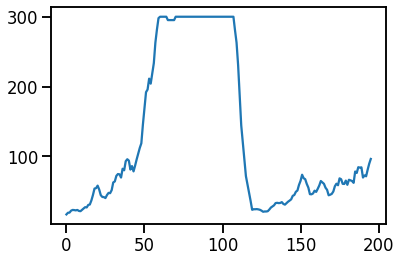

In [34]:
res = np.convolve(a.scores, np.ones(5,dtype=int),'valid') / 5
plt.plot(res)

In [61]:
a.play_ep(render=True)

In [96]:
env = gym.make('keygrid-v0', grid_length=8)
a = Reinforce(env)

0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
0
1
1
0
1
1
1
1
1
0
1
1
1
1
1
0
0
1
1
1
1
0
0
0
0
1
0
1
1
0
1
0
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
0
0
1
1
1
1
1
1
0
1
0
1
0
1
0
1
1
0
1
0
0
1
0
0
1
0
1
0
1
1
1
0
1
1
0
1
1
1
0
0
0
0
1
0
0
0
0
1
1
1
1
1
1
0
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
0
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
0
0
1
1
1
1
0
1
0
1
1
1
1
1
1
1
3
1
3
3
1
3
3
3
3
3
3
3
3
3
3
0
3
3
1
3
1
3
0
3
1
0
0
3
0
3
3
3
3
3
3
3
0
1
0
3
3
3
3
3
3
3
3
3
3
3
3
0
3
3
0
3
0
3
3
0
3
3
3
3
3
3
3
3
0
3
3
3
0
3
3
3
3
3
3
3
3
1
1
1
0
0
0
0
3
3
3
3
3
3
3
3
1
3
3
1
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0


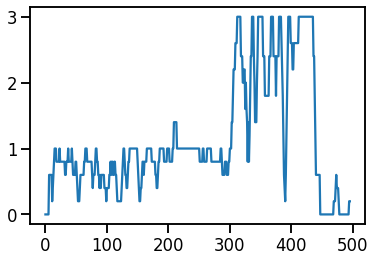

In [97]:
a.train(500)
res = np.convolve(a.scores, np.ones(5,dtype=int),'valid') / 5
plt.plot(res)

[[1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]]


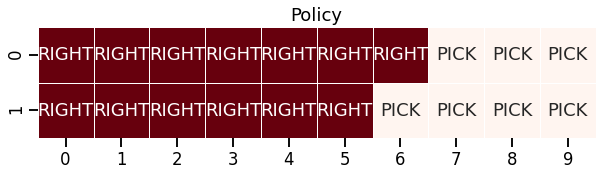

In [91]:
policy  = np.array([env.actions[a.get_action(x)] for x in env.states])
policy = policy.reshape((2, -1), order='F')
policy_display(policy)
print(policy)